In [1]:
import os
import shutil

base_dir = "/content/tiny-imagenet-200"
val_dir = os.path.join(base_dir, "val")
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

# Read annotations
with open(ann_file) as f:
    annotations = [line.strip().split('\t') for line in f]

# Create class folders and move images
for img, cls, *_ in annotations:
    cls_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    shutil.move(
        os.path.join(images_dir, img),
        os.path.join(cls_dir, img)
    )

os.rmdir(images_dir)

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfla
import tensorflow.keras.models as tfm
import tensorflow.keras.optimizers as tfo
import tensorflow.keras.losses as tflo
import matplotlib.pyplot as plt

In [3]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/train",
    image_size=(256, 256),
    batch_size=None,
    label_mode="int"
)

# load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [4]:
def crop_image(image, target_height=224, target_width=224):
  image = tf.image.random_crop(image, size=[target_height, target_width, 3])
  image = tf.image.random_flip_left_right(image)
  return image

In [5]:
train_ds = train_ds.map(lambda x, y : (crop_image(x), y))

In [6]:
train_ds = train_ds.batch(128)

In [7]:
def compute_mean_image(dataset):
  total = tf.zeros((224, 224, 3))
  num = 0
  for(images, _) in dataset:
    for(image) in images:
      total += image
    num += images.shape[0]

  return total / tf.cast(num, tf.float32)

In [8]:
per_pixel_mean = compute_mean_image(train_ds)
print(per_pixel_mean)

tf.Tensor(
[[[122.90612 122.80753 113.19051]
  [122.98422 122.86155 113.22568]
  [123.04648 122.89685 113.2442 ]
  ...
  [123.13246 122.8942  113.14972]
  [123.08583 122.87059 113.14511]
  [123.05444 122.86359 113.15209]]

 [[122.95246 122.81737 113.14731]
  [123.02266 122.86121 113.17457]
  [123.08369 122.89394 113.19016]
  ...
  [123.1917  122.911   113.11225]
  [123.14141 122.88581 113.10634]
  [123.10843 122.87605 113.11045]]

 [[122.99685 122.82041 113.09963]
  [123.05924 122.85601 113.11792]
  [123.1162  122.88426 113.12843]
  ...
  [123.2486  122.92372 113.07313]
  [123.20018 122.89935 113.07003]
  [123.16225 122.88573 113.07141]]

 ...

 [[114.62958 109.77444  95.47334]
  [114.66597 109.77438  95.45781]
  [114.70606 109.77698  95.44138]
  ...
  [114.75854 109.9296   95.63843]
  [114.73862 109.94226  95.66848]
  [114.71635 109.95262  95.69453]]

 [[114.62312 109.79754  95.51529]
  [114.6602  109.79724  95.49796]
  [114.70074 109.80244  95.48563]
  ...
  [114.76566 109.96611  95.

In [9]:
def substract_mean(images, labels):
  images = images - per_pixel_mean
  return images, labels

In [10]:
train_ds = train_ds.map(substract_mean)
test_ds = test_ds.map(substract_mean)

In [11]:
def collect_pixels(dataset, max_batch=20):
    all_pixels = []
    i = 0
    for images, _ in dataset:
        images = tf.cast(images, tf.float32)
        pixels = tf.reshape(images, [-1, 3])
        all_pixels.append(pixels)

        i+=1
        if(i >= max_batch):
            break


    return(tf.concat(all_pixels, axis=0))

def compute_pca(pixels):
    mean = tf.reduce_mean(pixels, axis=0)

    centered = pixels - mean

    cov = tf.matmul(centered, centered, transpose_a=True)
    cov /= tf.cast(tf.shape(centered)[0], tf.float32)

    eigvals, eigvecs = tf.linalg.eigh(cov)

    idx = tf.argsort(eigvals, direction="DESCENDING")
    eigvals = tf.gather(eigvals, idx)
    eigvecs = tf.gather(eigvecs, idx, axis=1)

    return(eigvals, eigvecs)

all_pixels = collect_pixels(train_ds, 100)
# we use first 100 batches, as using all the data will run out of
# ram
eigvals, eigvecs = compute_pca(all_pixels)
eigvals = eigvals / tf.reduce_max(eigvals)

print(eigvals)
print("\n")
print(eigvecs)

tf.Tensor([1.         0.09608129 0.01815144], shape=(3,), dtype=float32)


tf.Tensor(
[[ 0.5679214   0.72446287 -0.39066476]
 [ 0.58332735 -0.01941049  0.81200516]
 [ 0.5806847  -0.6890404  -0.4336225 ]], shape=(3, 3), dtype=float32)


In [12]:
def apply_pca_to_image(image, eigvals, eigvecs):
    alpha = tf.random.normal([3], mean=0.0, stddev=0.1)
    delta = tf.reduce_sum(eigvecs * eigvals * alpha, axis=1)

    return(tf.clip_by_value(image + delta, -128, 128))

def apply_pca_to_batch(images, labels):
    images = tf.cast(images, tf.float32)

    images = tf.map_fn(lambda img : apply_pca_to_image(img, eigvals, eigvecs), images)

    return(images, labels)

# apply pca to images
train_ds = train_ds.map(apply_pca_to_batch)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
def basic_block(x, filters, stride=1):
  shortcut = x

  if(stride != 1 or x.shape[-1] != filters):
    shortcut = tfla.Conv2D(filters, 1, strides=stride,kernel_initializer=tf.keras.initializers.HeNormal(),
                           padding='same', use_bias=False)(shortcut)
    shortcut = tfla.BatchNormalization()(shortcut)

  x = tfla.Conv2D(filters, 3, strides=stride, kernel_initializer=tf.keras.initializers.HeNormal(),
                  padding='same', use_bias=False)(x)
  x = tfla.BatchNormalization()(x)
  x = tfla.ReLU()(x)
  x = tfla.Conv2D(filters, 3, strides=1, kernel_initializer=tf.keras.initializers.HeNormal(),
                  padding='same', use_bias=False)(x)
  x = tfla.BatchNormalization(gamma_initializer="zeros")(x)

  x = tfla.Add()([x, shortcut])
  x = tfla.ReLU()(x)

  return x

In [14]:
inputs = tfla.Input(shape=(224, 224, 3))

x = tfla.Conv2D(64, 7, 2, kernel_initializer=tf.keras.initializers.HeNormal(),
                padding='same', use_bias = False)(inputs)
x = tfla.BatchNormalization()(x)
x = tfla.ReLU()(x)
x = tfla.MaxPool2D(3, 2, padding ='same')(x)

x = basic_block(x, 64)
x = basic_block(x, 64)

x = basic_block(x, 128, 2)
x = basic_block(x, 128)

x = basic_block(x, 256, 2)
x = basic_block(x, 256)

x = basic_block(x, 512, 2)
x = basic_block(x, 512)

x = tfla.GlobalAveragePooling2D()(x)
outputs = tfla.Dense(200)(x)

model = tfm.Model(inputs, outputs)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,288,712 (43.06 MB)

 Trainable params: 11,279,112 (43.03 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [16]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
def lr_schedule(epoch, lr):
  if epoch < 10:
    return(0.1)
  else:
    if(epoch < 20):
      return(0.01)
    else:
      return(0.001)

In [18]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(
    train_ds,
    epochs=30,
    callbacks=[lr_callback],
)

model.evaluate(test_ds)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 188s 206ms/step - accuracy: 0.0564 - loss: 4.7693 - learning_rate: 0.1000
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.1741 - loss: 3.7489 - learning_rate: 0.1000
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.2641 - loss: 3.2138 - learning_rate: 0.1000
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - accuracy: 0.3316 - loss: 2.8454 - learning_rate: 0.1000
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.3857 - loss: 2.5775 - learning_rate: 0.1000
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.4300 - loss: 2.3543 - learning_rate: 0.1000
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - accuracy: 0.4652 - loss: 2.1713 - learning_rate: 0.1000
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - accuracy: 0.5025 - loss: 2.0061 - learning_rate: 0.1000
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.5324 - loss: 1.857

[2.0596561431884766, 0.5512999892234802]

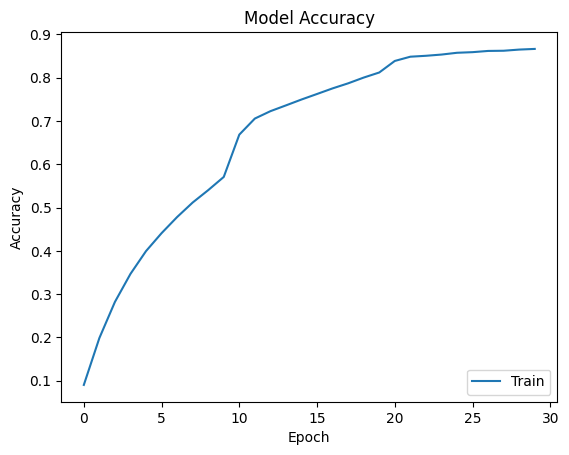

In [19]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()